Connect to Google Colab.

In [1]:
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab


Unzip train and test folder.

In [2]:
# !unzip train.zip
# !unzip test1.zip

Check for the amount of the datasets.

In [3]:
# trainset_path = os.listdir('/content/drive/MyDrive/Colab/train')
# testset_path = os.listdir('/content/drive/MyDrive/Colab/test1')
# print(f'Train images {len(trainset_path)}')
# print(f'Test images {len(testset_path)}')

Import packages and set reandom seeds.

In [4]:
import numpy as np
import cv2 as cv
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, auc
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.regularizers import L2
from tensorflow import keras

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Data loading and preprocessing functions

In [5]:
# Data loading and preprocessing functions
def load_and_preprocess_data(data_path):
    data = []
    labels = []

    for filename in os.listdir(data_path):
        img = cv.imread(os.path.join(data_path, filename))
        img = cv.resize(img, (64, 64))
        img = img / 255.0
        data.append(img)

        label = filename.split(".")[0]
        labels.append(1 if label == 'dog' else 0)

    return np.array(data), np.array(labels)

Data augmentation

In [6]:
# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(64,64,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Model creation function

In [7]:
# Model creation function
def create_model():
    model = Sequential([
        data_augmentation,
        layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(64, 64, 3), kernel_regularizer=L2(1e-3)),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=L2(1e-3)),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=L2(1e-3)),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=L2(1e-3)),
        layers.Dense(2)
    ])

    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model


Training function

In [8]:
# Training function
def train_model(model, train_x, train_y, val_x, val_y, batch_size=64, epochs=50):
    history = model.fit(
        x=train_x,
        y=train_y,
        validation_data=(val_x, val_y),
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size
    )
    return history

Evaluation function

In [9]:
# Evaluation function
def evaluate_model(model, val_x, val_y):
    val_predictions = model.predict(val_x)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    accuracy = accuracy_score(val_y, val_predictions_classes)
    precision = precision_score(val_y, val_predictions_classes)
    recall = recall_score(val_y, val_predictions_classes)

    conf_matrix = confusion_matrix(val_y, val_predictions_classes)
    fpr, tpr, _ = roc_curve(val_y, val_predictions[:, 1])  # Assuming 1 corresponds to 'dog' class
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, conf_matrix, fpr, tpr, roc_auc

Load and preprocess data. Split the train data into train and validation sets then creat and train the model.

In [10]:
# Load and preprocess data
train_x, train_y = load_and_preprocess_data('/content/drive/MyDrive/Colab/train')
test_x, test_y = load_and_preprocess_data('/content/drive/MyDrive/Colab/test1')

# Split train data into train and validation sets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Create and train the model
model = create_model()
history = train_model(model, train_x, train_y, val_x, val_y)


Epoch 1/50
313/313 [==============================] - 12s 18ms/step - loss: 0.7067 - accuracy: 0.6313 - val_loss: 0.6933 - val_accuracy: 0.6508
Epoch 2/50
313/313 [==============================] - 5s 17ms/step - loss: 0.6027 - accuracy: 0.7085 - val_loss: 0.5636 - val_accuracy: 0.7396
Epoch 3/50
313/313 [==============================] - 5s 16ms/step - loss: 0.5663 - accuracy: 0.7387 - val_loss: 0.5439 - val_accuracy: 0.7586
Epoch 4/50
313/313 [==============================] - 5s 16ms/step - loss: 0.5461 - accuracy: 0.7541 - val_loss: 0.5513 - val_accuracy: 0.7530
Epoch 5/50
313/313 [==============================] - 5s 17ms/step - loss: 0.5291 - accuracy: 0.7673 - val_loss: 0.5041 - val_accuracy: 0.7868
Epoch 6/50
313/313 [==============================] - 5s 15ms/step - loss: 0.5274 - accuracy: 0.7714 - val_loss: 0.5385 - val_accuracy: 0.7616
Epoch 7/50
313/313 [==============================] - 5s 16ms/step - loss: 0.5166 - accuracy: 0.7782 - val_loss: 0.4844 - val_accuracy: 0.804

Evaluation. Including the value of accuracy, precision and recall.

Plot the confusion matrix.

157/157 [==============================] - 0s 2ms/step
Accuracy: 0.8428
Precision: 0.8092
Recall: 0.8994


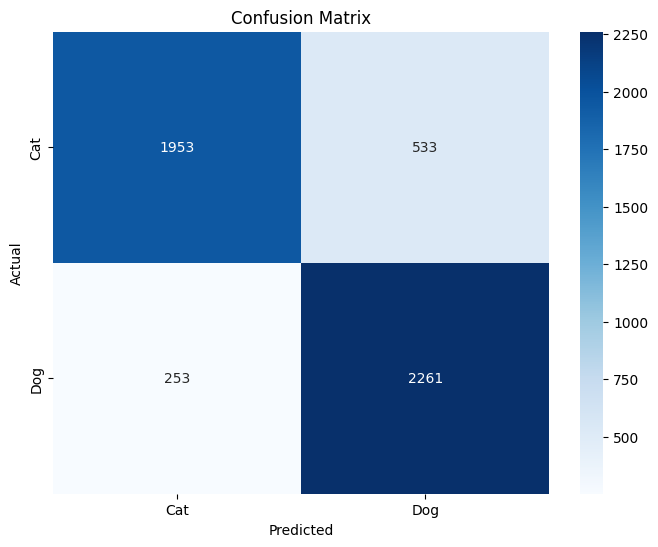

In [11]:
# Evaluate the model
accuracy, precision, recall, conf_matrix, fpr, tpr, roc_auc = evaluate_model(model, val_x, val_y)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Plotting the ROC curve.

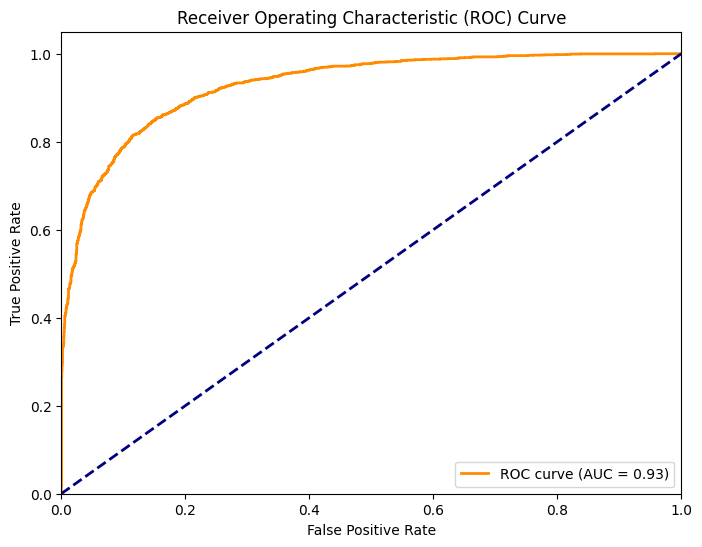

In [12]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()